In [1]:
import math
import pandas as pd
import numpy as np

#from CleaningFunctions import Clean

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import scipy
import scipy.stats as stats

In [2]:
# %load_ext autoreload
# %autoreload 2

Full_OMDB_Table.csv contains a list of movies (country USA, language English) from November 2014 to October 2019 taken from IMDB. Budget and revenue info are from IMDB as well.  Ratings (IMDB, Rotten Tomatoes and Metascore), released date, actors and production info are from OMDB, unoffical IMDB API.

In [3]:
#Convert csv to dataframe
df = pd.read_csv("Full_OMDB_Table.csv")
df.head()

,Title_ID,Release_Year,Runtime(Minutes),Genre,Title,Rating,Number_of_Votes,Budget(LCY),USA_Gross($),Worldwide_Gross($),Released_Date,Released_Month,Rotten_Tomatoes,Metascore,Actors,Production
0,tt0069049,2018,122,Drama,The Other Side of the Wind,6.9,4989,NaN,NaN,NaN,02 Nov 2018,11.0,83.0,78.0,"John Huston, Oja Kodar, Peter Bogdanovich, Sus...",Netflix
1,tt0339736,2017,98,Horror,The Evil Within,5.5,2572,$6000000,NaN,NaN,30 Aug 2017,8.0,100.0,NaN,"Sean Patrick Flanery, Dina Meyer, Frederick Ko...",NaN
2,tt0360556,2018,100,"Drama,Sci-Fi,Thriller",Fahrenheit 451,4.9,15295,NaN,NaN,NaN,20 May 2018,5.0,32.0,NaN,"Michael B. Jordan, Aaron Davis, Cindy Katz, Mi...",HBO Films
3,tt0365545,2018,98,"Comedy,Drama,Romance",Nappily Ever After,6.4,6718,NaN,NaN,NaN,21 Sep 2018,9.0,71.0,63.0,"Sanaa Lathan, Ricky Whittle, Lyriq Bent, Lynn ...",Netflix
4,tt0369610,2015,124,"Action,Adventure,Sci-Fi",Jurassic World,7.0,549806,$150000000,652.27,1670.4,12 Jun 2015,6.0,72.0,59.0,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...",Universal Pictures


In [4]:
df.columns

Index(['Title_ID', 'Release_Year', 'Runtime(Minutes)', 'Genre', 'Title',
       'Rating', 'Number_of_Votes', 'Budget(LCY)', 'USA_Gross($)',
       'Worldwide_Gross($)', 'Released_Date', 'Released_Month',
       'Rotten_Tomatoes', 'Metascore', 'Actors', 'Production'],
      dtype='object')

### Is it more profitable to release movies during the winter months in the US?

Test is focused on last 5 years English movies released in the US taken from IMDB.  Profitability will be measured using the budget (converted into USD) and gross US revenue (both in millions) scraped from each of the movie IMDB webpages. t-test will be performed on the mean profits of winter (Dec, Jan, Feb) and summer (Jun, Jul, Aug) movies.

#### Perform EDA on  the data taken from IMDB.  Check for null values and outliers.

In [5]:
#Get the columns needed for the test:  movies released during the winter months more profitable
df_season_revenue = df[["Title_ID","Release_Year","Released_Month","Title","Genre","Budget(LCY)", "USA_Gross($)"]]
df_season_revenue.head()

,Title_ID,Release_Year,Released_Month,Title,Genre,Budget(LCY),USA_Gross($)
0,tt0069049,2018,11.0,The Other Side of the Wind,Drama,NaN,NaN
1,tt0339736,2017,8.0,The Evil Within,Horror,$6000000,NaN
2,tt0360556,2018,5.0,Fahrenheit 451,"Drama,Sci-Fi,Thriller",NaN,NaN
3,tt0365545,2018,9.0,Nappily Ever After,"Comedy,Drama,Romance",NaN,NaN
4,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",$150000000,652.27


In [6]:
#Check dtype and for null values
display(df_season_revenue.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 7 columns):
Title_ID          2015 non-null object
Release_Year      2015 non-null int64
Released_Month    2005 non-null float64
Title             2015 non-null object
Genre             2015 non-null object
Budget(LCY)       1004 non-null object
USA_Gross($)      1085 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 110.3+ KB


None

In [7]:
#Drop null values under the money columns
df_season_revenue.dropna(subset = ["Budget(LCY)", "USA_Gross($)"], inplace = True)
df_season_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 4 to 2004
Data columns (total 7 columns):
Title_ID          771 non-null object
Release_Year      771 non-null int64
Released_Month    771 non-null float64
Title             771 non-null object
Genre             771 non-null object
Budget(LCY)       771 non-null object
USA_Gross($)      771 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 48.2+ KB


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
#Convert budget column to USD, use current exchange rate
df_season_revenue["Budget($)"] = pd.Series([])

for i in range(len(df_season_revenue)):
    if str(df_season_revenue["Budget(LCY)"].iloc[i])[0] == "$":
        df_season_revenue["Budget($)"].iloc[i] = int(str(df_season_revenue["Budget(LCY)"].iloc[i]).replace("$",""))/1000000
    elif str(df_season_revenue["Budget(LCY)"].iloc[i])[0:3] == "EUR":
        df_season_revenue["Budget($)"].iloc[i] = int(str(df_season_revenue["Budget(LCY)"].iloc[i]).replace("EUR",""))/1000000 * 1.1
    elif str(df_season_revenue["Budget(LCY)"].iloc[i])[0:3] == "GBP":
        df_season_revenue["Budget($)"].iloc[i] = int(str(df_season_revenue["Budget(LCY)"].iloc[i]).replace("GBP",""))/1000000 * 1.28
    elif str(df_season_revenue["Budget(LCY)"].iloc[i])[0:3] == "CAD":
        df_season_revenue["Budget($)"].iloc[i] = int(str(df_season_revenue["Budget(LCY)"].iloc[i]).replace("CAD",""))/1000000 * 0.75
    else:
        continue
        
df_season_revenue.drop(columns = ["Budget(LCY)"], axis = 1, inplace = True)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [9]:
df_season_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 4 to 2004
Data columns (total 7 columns):
Title_ID          771 non-null object
Release_Year      771 non-null int64
Released_Month    771 non-null float64
Title             771 non-null object
Genre             771 non-null object
USA_Gross($)      771 non-null float64
Budget($)         771 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 48.2+ KB


In [10]:
#Add categorial columns for the seasons
df_months = pd.DataFrame({"Released_Month" : list(range(1,13)), "Season" : [1,1,2,2,2,3,3,3,4,4,4,1], "Season_" : [1,1,2,2,2,2,2,2,1,1,1,1]})
df_season_revenue = pd.merge(df_season_revenue, df_months, on = "Released_Month")
df_season_revenue

,Title_ID,Release_Year,Released_Month,Title,Genre,USA_Gross($),Budget($),Season,Season_
0,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",652.27,150.00,3,2
1,tt0451279,2017,6.0,Wonder Woman,"Action,Adventure,Fantasy",412.56,149.00,3,2
2,tt1124037,2016,6.0,Free State of Jones,"Action,Biography,Drama",20.81,50.00,3,2
3,tt1489889,2016,6.0,Central Intelligence,"Action,Comedy,Crime",127.44,50.00,3,2
4,tt1628841,2016,6.0,Independence Day: Resurgence,"Action,Adventure,Sci-Fi",103.14,165.00,3,2
...,...,...,...,...,...,...,...,...,...
766,tt7547410,2019,8.0,Dora and the Lost City of Gold,"Adventure,Family",60.48,49.00,3,2
767,tt7668870,2018,8.0,Searching,"Drama,Mystery,Thriller",26.02,0.88,3,2
768,tt7798634,2019,8.0,Ready or Not,"Comedy,Horror,Mystery",28.71,6.00,3,2
769,tt8186318,2019,8.0,Overcomer,"Drama,Sport",34.70,5.00,3,2


In [11]:
#Calculate profit
df_season_revenue["Profit(%)"] = round((df_season_revenue["USA_Gross($)"] / df_season_revenue["Budget($)"]) - 1, 2)

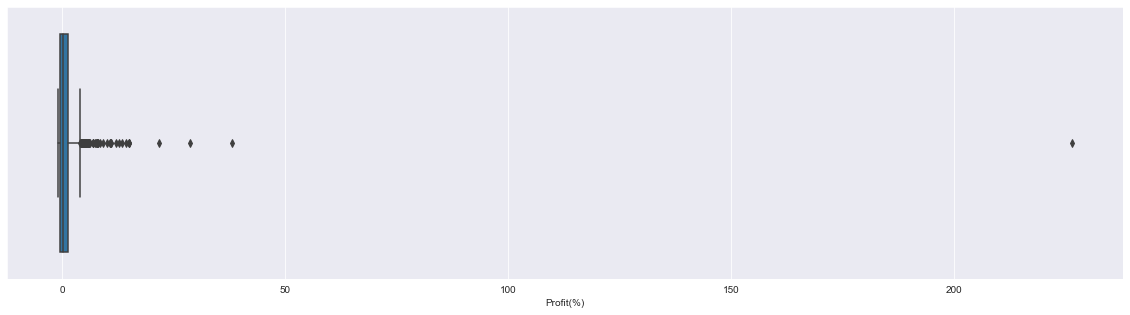

In [12]:
#Check the distribution of the profit column
plt.figure(figsize = [20,5])
sns.boxplot(df_season_revenue["Profit(%)"])

In [13]:
df_season_revenue["Profit(%)"].describe()

count    771.000000
mean       1.206615
std        8.641546
min       -1.000000
25%       -0.550000
50%        0.060000
75%        1.285000
max      226.600000
Name: Profit(%), dtype: float64

In [14]:
#The above boxplot and table are showing 4 outliers above 15/20%
#Remove the outliers profit > 15%
df_season_outliers = df_season_revenue[df_season_revenue["Profit(%)"] > 15]
df_season_outliers

,Title_ID,Release_Year,Released_Month,Title,Genre,USA_Gross($),Budget($),Season,Season_,Profit(%)
171,tt5052448,2017,2.0,Get Out,"Horror,Mystery,Thriller",176.04,4.50,1,1,38.12
260,tt2309260,2015,7.0,The Gallows,"Horror,Mystery,Thriller",22.76,0.10,3,2,226.60
732,tt3832914,2015,8.0,War Room,Drama,67.79,3.00,3,2,21.60
767,tt7668870,2018,8.0,Searching,"Drama,Mystery,Thriller",26.02,0.88,3,2,28.57


In [15]:
df_season_revenue = df_season_revenue[df_season_revenue["Profit(%)"] <= 15]
df_season_revenue

,Title_ID,Release_Year,Released_Month,Title,Genre,USA_Gross($),Budget($),Season,Season_,Profit(%)
0,tt0369610,2015,6.0,Jurassic World,"Action,Adventure,Sci-Fi",652.27,150.0,3,2,3.35
1,tt0451279,2017,6.0,Wonder Woman,"Action,Adventure,Fantasy",412.56,149.0,3,2,1.77
2,tt1124037,2016,6.0,Free State of Jones,"Action,Biography,Drama",20.81,50.0,3,2,-0.58
3,tt1489889,2016,6.0,Central Intelligence,"Action,Comedy,Crime",127.44,50.0,3,2,1.55
4,tt1628841,2016,6.0,Independence Day: Resurgence,"Action,Adventure,Sci-Fi",103.14,165.0,3,2,-0.37
...,...,...,...,...,...,...,...,...,...,...
765,tt7365604,2018,8.0,Dog Days,"Comedy,Drama,Romance",6.81,10.0,3,2,-0.32
766,tt7547410,2019,8.0,Dora and the Lost City of Gold,"Adventure,Family",60.48,49.0,3,2,0.23
768,tt7798634,2019,8.0,Ready or Not,"Comedy,Horror,Mystery",28.71,6.0,3,2,3.78
769,tt8186318,2019,8.0,Overcomer,"Drama,Sport",34.70,5.0,3,2,5.94


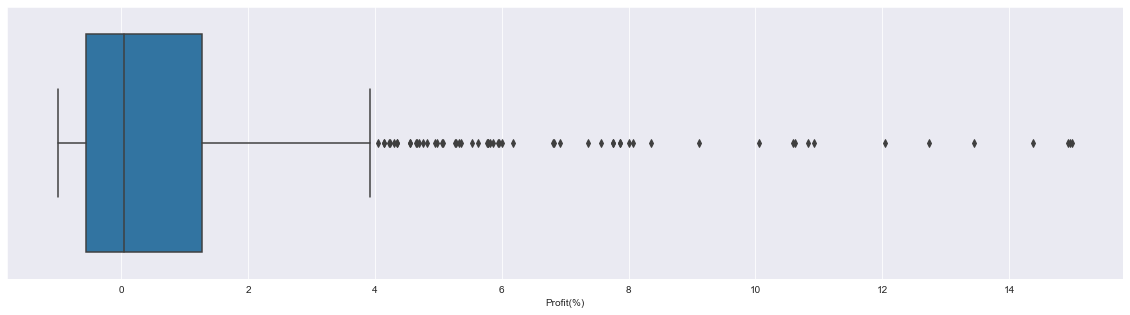

In [16]:
plt.figure(figsize = [20,5])
sns.boxplot(df_season_revenue["Profit(%)"])

In [17]:
#Create a subset for winter movies
df_winter = df_season_revenue[(df_season_revenue["Season"] == 1)]
df_winter["Profit(%)"].describe()

count    193.000000
mean       0.697306
std        1.944261
min       -1.000000
25%       -0.560000
50%        0.130000
75%        1.290000
max       14.370000
Name: Profit(%), dtype: float64

In [18]:
#Create a subset for summer movies which will be tested against winter movies
df_summer = df_season_revenue[(df_season_revenue["Season"] == 3)]
df_summer["Profit(%)"].describe()

count    188.000000
mean       1.043511
std        2.392632
min       -1.000000
25%       -0.427500
50%        0.310000
75%        1.687500
max       15.000000
Name: Profit(%), dtype: float64

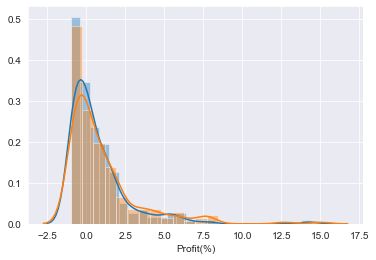

In [19]:
#Check distribution
sns.distplot(df_winter["Profit(%)"])
sns.distplot(df_summer["Profit(%)"])

#### For the above subsets, perform random sampling then compare sample variances and check for normality.

H0: sample comes from a normal distribution

HA: sample does not from a normal distribution

In [20]:
#Below functions perform random sampling and calculate for sample variance
def get_sample_mean(sample):
    return sum(sample) / len(sample)
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)  
    return sample
def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist
def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)

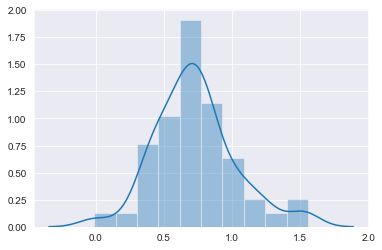

NormaltestResult(statistic=4.576131733291613, pvalue=0.10146251423001887)

In [38]:
#Perfom random sampling and normality test on winter movies
winter_sample = create_sample_distribution(df_winter["Profit(%)"], dist_size=50, n=30)
sns.distplot(winter_sample)
plt.show()
stats.normaltest(winter_sample)

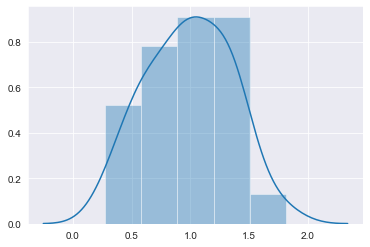

NormaltestResult(statistic=1.3455871569630253, pvalue=0.5102810745643368)

In [41]:
#Perfom random sampling and normality test on summer movies
summer_sample = create_sample_distribution(df_summer["Profit(%)"], dist_size=50, n=30)
sns.distplot(summer_sample)
plt.show()
stats.normaltest(summer_sample)

In [39]:
winter_variance = sample_variance(winter_sample)
winter_mean = np.mean(winter_sample)
print("winter sample mean is", winter_mean)
print("winter sample variance is", winter_variance)

winter sample mean is 0.7287399999999999
winter sample variance is 0.09009959768707483


In [42]:
summer_variance = sample_variance(summer_sample)
summer_mean = np.mean(summer_sample)
print("summer sample mean is", summer_mean)
print("summer sample variance is", summer_variance)

summer sample mean is 0.9875599999999998
summer sample variance is 0.13051455981859408


In [43]:
winter_mean - summer_mean

-0.25881999999999983

 - p-values for the above normality tests are greater than the alpha = 0.05, H0 cannot be rejected then

 - winter and summer movie samples have similar variance

#### Perform one-tailed and two-tailed t-tests (alpha = 0.05)

H0: The mean profit difference between winter and summer movies is equal to zero (winter - summer = 0)

HA1: The mean profit difference between winter and summer movies is not equal to zero (winter - summer != 0)

HA2: The mean profit difference between winter and summer movies is greater than zero (winter - summer > 0)

In [44]:
alpha = 0.05
df = len(winter_sample) + len(summer_sample) -2
t_stat, p_value = stats.ttest_ind(winter_sample, summer_sample) #two-tailed p-value
HA1_p_value = p_value #two-tailed p-value
HA2_p_value = 1 - p_value/2 # 1- two-tailed p-value / 2 
t_crit = stats.t.ppf(1 - alpha, df) #same for all null and alternative hypotheses

In [45]:
#HA1: The mean profit difference between winter and summer movies is not equal to zero (winter - summer != 0)

print("t-statistic is ", t_stat)
print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", HA1_p_value)

t-statistic is  -3.896423424007677
t-critical value is  1.6605512170440568 (alpha =  0.05 and degress of freedom =  98 )
p-value is  0.0001785788452731913


p-value < alpha therefore we reject the null hypothesis in support of the alternative

In [46]:
#HA2: The mean profit difference between winter and summer movies is greater than zero (winter - summer > 0)

print("t-statistic is ", t_stat)
print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", HA2_p_value)

t-statistic is  -3.896423424007677
t-critical value is  1.6605512170440568 (alpha =  0.05 and degress of freedom =  98 )
p-value is  0.9999107105773634


p-value > alpha therefore we do not reject the null hypothesis in support of the alternative

### Are comedy movies more profitable than dramas in the US?

Test is focused on last 5 years English movies released in the US taken from IMDB.  Profitability will be measured using the budget (converted into USD) and gross US revenue (both in millions) scraped from each of the movie IMDB webpages. t-test will be performed on the mean profits of comedy and drama movies.

#### Perform EDA on  the data taken from IMDB.

Cleaned data *df_season_revenue* will be used as a starting point.

In [47]:
df_genre_revenue = df_season_revenue[['Title_ID', 'Release_Year', 'Title', 'Genre','USA_Gross($)', 'Budget($)','Profit(%)']]
df_genre_revenue

,Title_ID,Release_Year,Title,Genre,USA_Gross($),Budget($),Profit(%)
0,tt0369610,2015,Jurassic World,"Action,Adventure,Sci-Fi",652.27,150.0,3.35
1,tt0451279,2017,Wonder Woman,"Action,Adventure,Fantasy",412.56,149.0,1.77
2,tt1124037,2016,Free State of Jones,"Action,Biography,Drama",20.81,50.0,-0.58
3,tt1489889,2016,Central Intelligence,"Action,Comedy,Crime",127.44,50.0,1.55
4,tt1628841,2016,Independence Day: Resurgence,"Action,Adventure,Sci-Fi",103.14,165.0,-0.37
...,...,...,...,...,...,...,...
765,tt7365604,2018,Dog Days,"Comedy,Drama,Romance",6.81,10.0,-0.32
766,tt7547410,2019,Dora and the Lost City of Gold,"Adventure,Family",60.48,49.0,0.23
768,tt7798634,2019,Ready or Not,"Comedy,Horror,Mystery",28.71,6.0,3.78
769,tt8186318,2019,Overcomer,"Drama,Sport",34.70,5.0,5.94


In [48]:
#Create subsets for comedy movies.  All movies under genre comedy but not drama
q1 = """SELECT * FROM df_genre_revenue WHERE Genre LIKE "%Comedy%" AND Genre NOT LIKE "%Drama%";"""
df_genre_comedy = pysqldf(q1)
df_genre_comedy["Profit(%)"].describe()

count    171.000000
mean       0.700000
std        1.447587
min       -1.000000
25%       -0.270000
50%        0.380000
75%        1.265000
max        9.110000
Name: Profit(%), dtype: float64

In [49]:
#Create subsets for drama movies.  All movies under genre drama but not comedy
q2 = """SELECT * FROM df_genre_revenue WHERE Genre LIKE "%Drama%" AND Genre NOT LIKE "%Comedy%";"""
df_genre_drama = pysqldf(q2)
df_genre_drama["Profit(%)"].describe()

count    312.000000
mean       0.644904
std        2.298956
min       -1.000000
25%       -0.712500
50%       -0.130000
75%        1.080000
max       15.000000
Name: Profit(%), dtype: float64

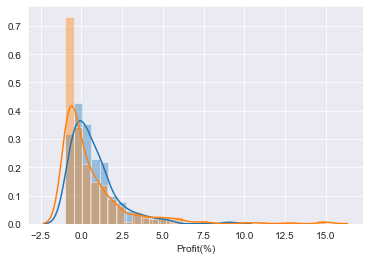

In [50]:
#Check distribution
sns.distplot(df_genre_comedy["Profit(%)"])
sns.distplot(df_genre_drama["Profit(%)"])

#### For the above subsets, perform random sampling then compare sample variances and check for normality.

H0: sample comes from a normal distribution

HA: sample does not from a normal distribution

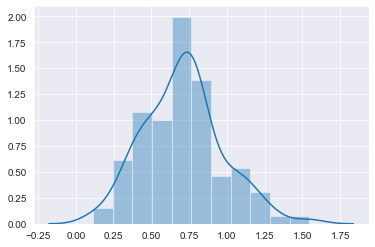

NormaltestResult(statistic=3.3027101244416044, pvalue=0.1917898452858675)

In [51]:
#Perfom random sampling and normality test on comedy movies
comedy_sample = create_sample_distribution(df_genre_comedy["Profit(%)"], dist_size=100, n=30)
sns.distplot(comedy_sample)
plt.show()
stats.normaltest(comedy_sample)

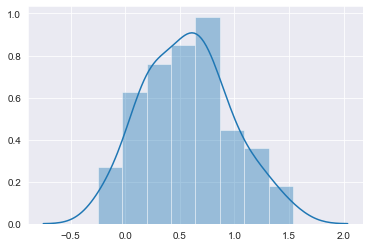

NormaltestResult(statistic=1.4645076918971245, pvalue=0.48082406455209514)

In [52]:
#Perfom random sampling and normality test on comedy movies
drama_sample = create_sample_distribution(df_genre_drama["Profit(%)"], dist_size=100, n=30)
sns.distplot(drama_sample)
plt.show()
stats.normaltest(drama_sample)

In [53]:
comedy_variance = sample_variance(comedy_sample)
comedy_mean = np.mean(comedy_sample)
print("comedy sample mean is", comedy_mean)
print("comedy sample variance is", comedy_variance)

comedy sample mean is 0.7077266666666666
comedy sample variance is 0.06928283362514029


In [54]:
drama_variance = sample_variance(drama_sample)
drama_mean = np.mean(drama_sample)
print("drama sample mean is", drama_mean)
print("drama sample variance is", drama_variance)

drama sample mean is 0.5686399999999999
drama sample variance is 0.15669375461279467


In [55]:
comedy_mean - drama_mean

0.1390866666666667

 - p-values for the above normality tests are greater than the alpha = 0.05, H0 cannot be rejected then

 - comedy and drama movie samples have similar variance

#### Perform one-tailed and two-tailed t-tests (alpha = 0.05)

H0: The mean profit difference between comedy and drama movies is equal to zero (comedy - drama = 0)

HA1: The mean profit difference between comedy and drama movies is not equal to zero (comedy - drama != 0)

HA2: The mean profit difference between comedy and drama movies is greater than zero (comedy - drama > 0)

In [56]:
alpha = 0.05
df = len(comedy_sample) + len(drama_sample) -2
t_stat, p_value = stats.ttest_ind(comedy_sample, drama_sample) #two-tailed p-value
HA1_p_value = p_value #two-tailed p-value
HA2_p_value = 1 - p_value/2 # 1- two-tailed p-value / 2 
t_crit = stats.t.ppf(1 - alpha, df) #same for all null and alternative hypotheses

In [57]:
#HA1: The mean profit difference between comedy and drama movies is not equal to zero (comedy - drama != 0)

print("t-statistic is ", t_stat)
print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", HA1_p_value)

t-statistic is  2.92586157397836
t-critical value is  1.6525857836172075 (alpha =  0.05 and degress of freedom =  198 )
p-value is  0.0038363226915525944


p-value < alpha therefore we reject the null hypothesis in support of the alternative

In [58]:
#HA2: The mean profit difference between comedy and drama movies is greater than zero (comedy - drama > 0)

print("t-statistic is ", t_stat)
print("t-critical value is ", t_crit, "(alpha = ", alpha, "and degress of freedom = ", df, ")")
print("p-value is ", HA2_p_value)

t-statistic is  2.92586157397836
t-critical value is  1.6525857836172075 (alpha =  0.05 and degress of freedom =  198 )
p-value is  0.9980818386542237


p-value > alpha therefore we do not reject the null hypothesis in support of the alternative